# Install ORTEGA

In [1]:
!pip install ortega

In [1]:
import pandas as pd
import ortega

# Read movement data of two moving entities
The input data must contain following fields: unique id for the two moving entities, and longitude, latitude, and local time for each tracking point.

The time field must be converted to datetime type and the value must contains year, month, day, hour, minute, and second. 

In [3]:
bigdata = pd.read_csv('./data/Mother_Young1.csv', sep=',',header=0)
bigdata['Time_LMT'] = pd.to_datetime(bigdata.Time_LMT)
print('total number of gps points:', bigdata.shape[0])

# Convert longitude latitude to epsg:3857
If tracking data are already in projected coordinate system, users can skip this step. Otherwise, longitude and latitude coordinates need to be converted to projected coordinate system coordinates. We recommend using the epsg:3857 projected coordinate system because it is used for rendering maps in many common apps such as Google Maps, OpenStreetMap, etc.

In [5]:
!pip install pyproj fastkml shapely

In [6]:
%%time
import pyproj
from fastkml import kml
from shapely.geometry import Point
from shapely.ops import transform

p = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def convert_to_projected(x, lat, lon):
    point = Point(float(x[lon]), float(x[lat]))
    projected_point = transform(p.transform, point)
    x[lat], x[lon] = projected_point.y, projected_point.x
    return x

bigdata = bigdata.apply(lambda x: convert_to_projected(x, 'latitude', 'longitude'), axis=1)

C:\Users\Yifei\.conda\envs\geo_env\lib\site-packages\fastkml\config.py:28: UserWarning: Package `lxml` missing. Pretty print will be disabled
  warnings.warn("Package `lxml` missing. Pretty print will be disabled")


Wall time: 1.51 s


# Initializing ORTEGA object
Parameters of ORTEGA class:
1. start_time, end_time: They can be used to select the portion of movement data that falls in this time interval.
2. minute_delay: The allowable time lag parameter in minutes. Usually, this number should be greater than the temporal resolution of movement data.
3. max_el_time_min: If the time interval between two consecutive points is larger than this parameter, ORTEGA will not create PPA and treat this time interval as a stationary activity when individuals are not moving.
4. latitude_field, longitude_field, id_field, time_field: users need to specify these field names according to the data they used.

In [8]:
interaction1 = ortega.ORTEGA(data=bigdata,
                             start_time='2020-01-01 00:00:00',  ##set a time window to subset data
                             end_time='2020-01-10 00:00:00',
                             minute_min_delay=0,
                             minute_max_delay=60,
                             latitude_field = 'latitude',
                             longitude_field = 'longitude',                             
                             time_field='Time_LMT',
                             id_field='idcollar',
                             speed_average=True
                             )

2023-06-29 09:22:31.653201 Initializing ORTEGA object...
2023-06-29 09:22:31.659198 Generate PPA list for the two moving entities...
2023-06-29 09:22:31.753747 Generating PPA list completed!
2023-06-29 09:22:31.753747 Initialization success!


# Implement interaction analysis

The below cell runs interaction_analysis() and returns a ORTEGAResults object containing three attributes.
- intersection_ellipse_pair: a list of intersecting PPA pairs as paired built-in Ellipse objects.
- df_all_intersection_pairs: a dataframe containing all intersecting PPA pairs. 
- df_interaction_events: a dataframe that includes all identified continuous interaction segments (interaction events).

In [9]:
results = interaction1.interaction_analysis()

2023-06-29 09:22:33.789038 Implement interaction analysis...
2023-06-29 09:22:34.135287 Complete! 243 pairs of intersecting PPAs found!
2023-06-29 09:22:34.150831 Compute duration of interaction...
2023-06-29 09:22:34.150831 Complete! 10 interaction events identified!


In results.df_interaction_events, the dataframe contains the start and end times of each intersecting segment as well as the time difference between these two segments. The time difference is the difference between the start times of the two segments.

In [ ]:
results.df_interaction_events

If the interaction is concurrent, users may call compute_interaction_duration() to derive the duration of that interaction event (unit in minutes). The return value is invalid if apply on delayed interaction. 

In [ ]:
results.compute_interaction_duration()

The beblow results indicate 10 interaction events between these two moving entities.
The dataframe results.df_interaction_events includes 8 columns: 
- p1: unique id for individual 1
- p2: unique id for individual 2
- p1_start: start time of the intersecting segment of p1
- p1_end: end time of the intersecting segment of p1
- p2_start: start time of the intersecting segment of p2
- p2_end: end time of the intersecting segment of p2
- difference: time lag between the two intersecting segments
- duration: duration of the interaction event (in minutes)

In [10]:
results.df_interaction_events

,No,P1,P2,Start,End,Duration
0,1,Mother,Young1,2020-01-01 13:00:00,2020-01-02 09:00:00,1200.0
1,2,Mother,Young1,2020-01-02 14:00:00,2020-01-03 09:00:00,1140.0
2,3,Mother,Young1,2020-01-03 12:00:00,2020-01-03 16:00:00,240.0
3,4,Mother,Young1,2020-01-03 18:00:00,2020-01-04 04:00:00,600.0
4,5,Mother,Young1,2020-01-04 05:00:00,2020-01-04 09:00:00,240.0
5,6,Mother,Young1,2020-01-04 10:00:00,2020-01-04 22:00:00,720.0
6,7,Mother,Young1,2020-01-06 04:00:00,2020-01-06 21:00:00,1020.0
7,8,Mother,Young1,2020-01-07 18:00:00,2020-01-08 12:00:00,1080.0
8,9,Mother,Young1,2020-01-08 13:00:00,2020-01-08 22:00:00,540.0
9,10,Mother,Young1,2020-01-09 01:00:00,2020-01-09 10:00:00,540.0


# Compute PPA size and use violin plots to show the distribution

In [11]:
ppasize_list = interaction1.compute_ppa_size()

Descriptive statistics of PPA ellipses length for id Mother:
count      211.000000
mean      1324.035782
std       1757.507667
min         25.528807
25%        127.670291
50%        515.875576
75%       1820.844345
max      10706.359135
dtype: float64
Descriptive statistics of PPA ellipses length for id Young1:
count     208.000000
mean      528.756596
std       864.573979
min        25.561556
25%        87.754234
50%       198.321049
75%       569.410007
max      8374.730500
dtype: float64


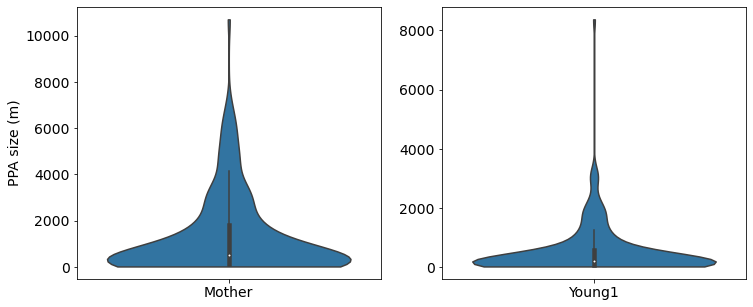

In [12]:
import seaborn
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=ppasize_list[0], ax=ax1,cut=0)
seaborn.violinplot(data=ppasize_list[1], ax=ax2,cut=0)
ax1.set_xticklabels([str(interaction1.id1)])
ax2.set_xticklabels([str(interaction1.id2)])
ax1.set_ylabel('PPA size (m)')
# ax2.set_ylabel('PPA size (m)')
plt.show()

# Compute PPA speed and use violin plots to show the distribution

In [13]:
ppaspeed_list = interaction1.compute_ppa_speed()

Descriptive statistics of PPA ellipses length for id Mother:
count    211.000000
mean       0.084542
std        0.135932
min        0.000128
25%        0.004209
50%        0.011579
75%        0.104998
max        0.654730
dtype: float64
Descriptive statistics of PPA ellipses length for id Young1:
count    208.000000
mean       0.031667
std        0.058392
min        0.000172
25%        0.002977
50%        0.005961
75%        0.022891
max        0.358609
dtype: float64


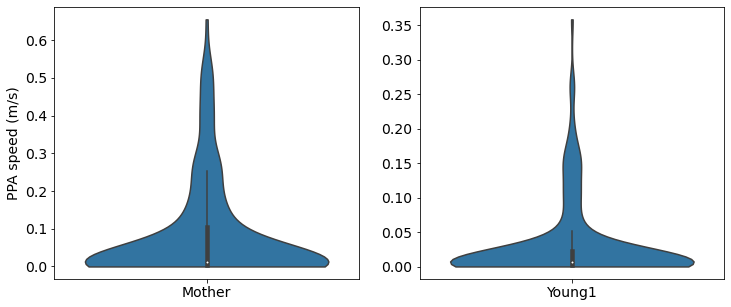

In [14]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=ppaspeed_list[0], ax=ax1,cut=0)
seaborn.violinplot(data=ppaspeed_list[1], ax=ax2,cut=0)
ax1.set_xticklabels([str(interaction1.id1)])
ax2.set_xticklabels([str(interaction1.id2)])
ax1.set_ylabel('PPA speed (m/s)')
# ax2.set_ylabel('PPA speed (m/s)')
plt.show()

# Compute PPA interval and use violin plot to show the distribution

In [15]:
interval_list = interaction1.compute_ppa_interval()

Descriptive statistics of PPA ellipses time interval (minutes) for id Mother:
count    211.000000
mean      61.421801
std        9.237981
min       57.000000
25%       60.000000
50%       60.000000
75%       60.000000
max      122.000000
Name: Time_LMT, dtype: float64
Descriptive statistics of PPA ellipses time interval (minutes) for id Young1:
count    208.000000
mean      62.307692
std       18.547538
min       57.000000
25%       60.000000
50%       60.000000
75%       60.000000
max      300.000000
Name: Time_LMT, dtype: float64


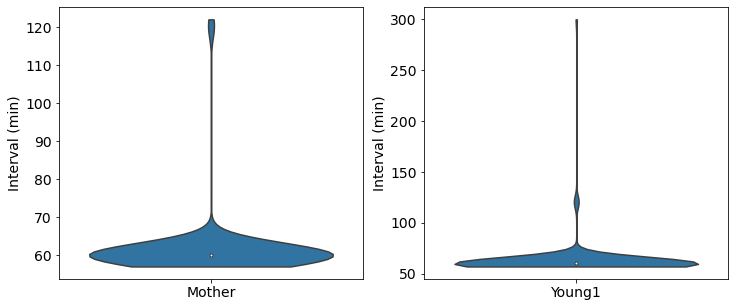

In [16]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=interval_list[0].tolist(), ax=ax1,cut=0)
seaborn.violinplot(data=interval_list[1].tolist(), ax=ax2,cut=0)
ax1.set_xticklabels([interaction1.id1])
ax2.set_xticklabels([interaction1.id2])
ax1.set_ylabel('Interval (min)')
ax2.set_ylabel('Interval (min)')
plt.show()

# Map the results of interaction analysis
two tracks are shown in blue and red ellipses respectively, intersecting PPAs are highlighted in yellow

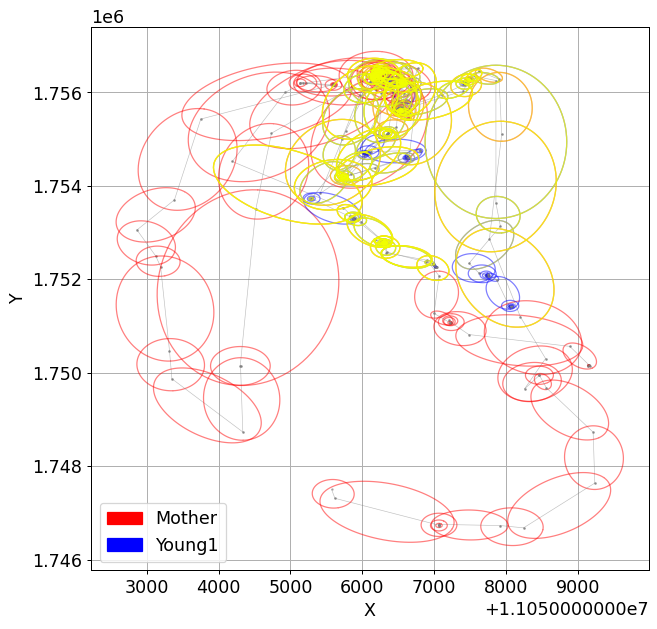

In [17]:
ortega.visualization.plot_interaction(interaction1, results.intersection_ellipse_pair)

map the original tracks without annotating intersecting portion

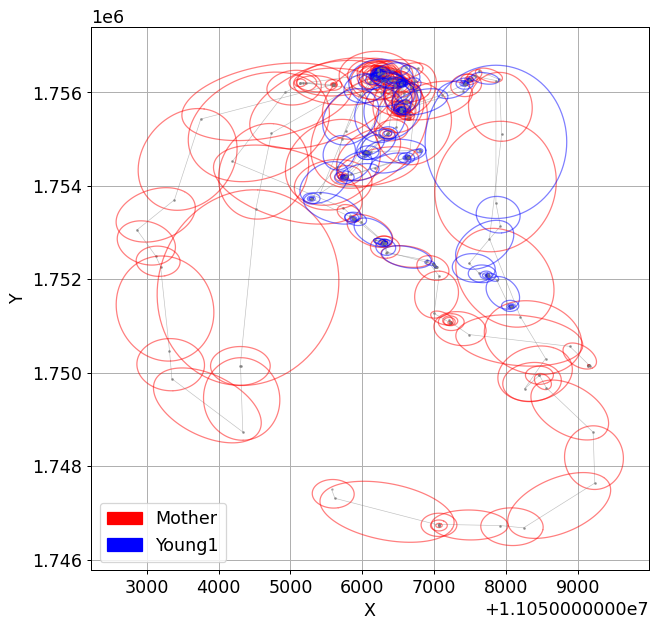

In [18]:
ortega.visualization.plot_original_tracks(interaction1) 

# Explore the difference in speed and movement  direction when individuals interact

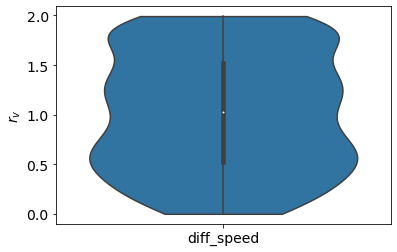

In [19]:
plt.rcParams.update({'font.size': 14})
ax = seaborn.violinplot(data=df_intersecting_PPAs['diff_speed'].tolist(),cut=0)
ax.set_xticklabels(['diff_speed'])
ax.set_ylabel(r'$r_v$')
plt.show()

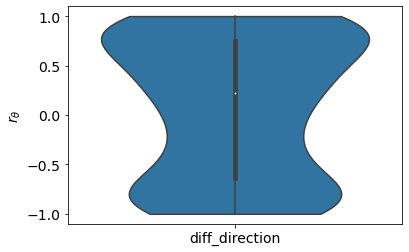

In [20]:
plt.rcParams.update({'font.size': 14})
ax = seaborn.violinplot(data=df_intersecting_PPAs['diff_direction'].tolist(),cut=0)
ax.set_xticklabels(['diff_direction'])
ax.set_ylabel(r'$r_\theta$')
plt.show()